# Advanced Lane Finding Project
The goals / steps of this project are the following:

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
Apply a distortion correction to raw images.
Use color transforms, gradients, etc., to create a thresholded binary image.
Apply a perspective transform to rectify binary image ("birds-eye view").
Detect lane pixels and fit to find the lane boundary.
Determine the curvature of the lane and vehicle position with respect to center.
Warp the detected lane boundaries back onto the original image.
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from CV_function import calculation_undistort, image_computing, warper, find_lanes_pixels, fit_polynomial,calculation_curvature,calculation_vehicle_position, vizualization
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#%matplotlib inline


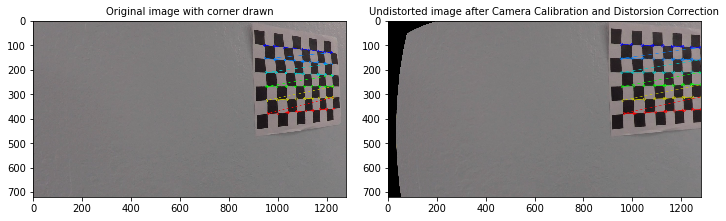

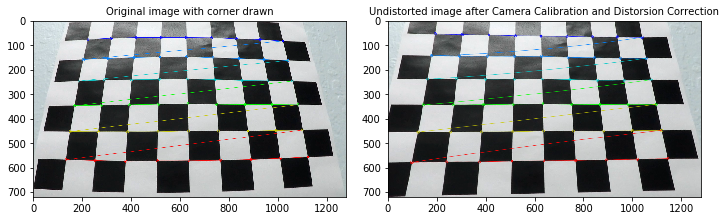

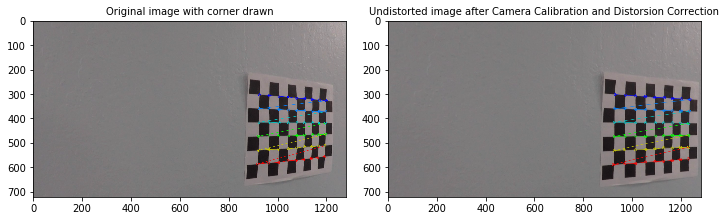

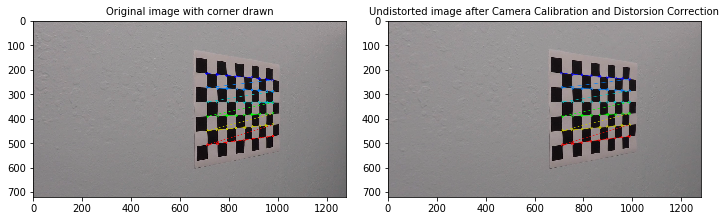

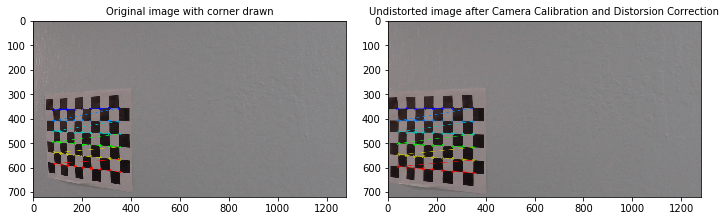

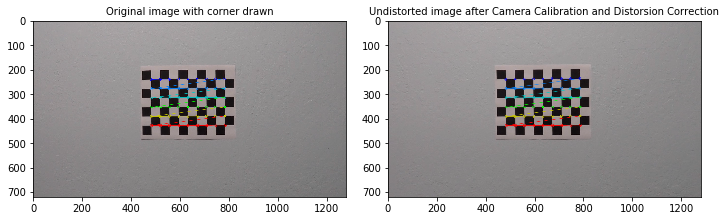

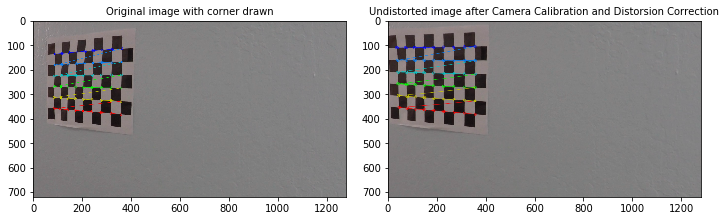

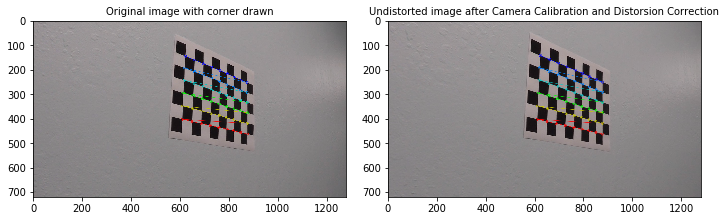

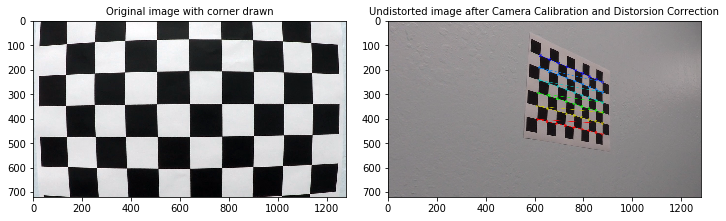

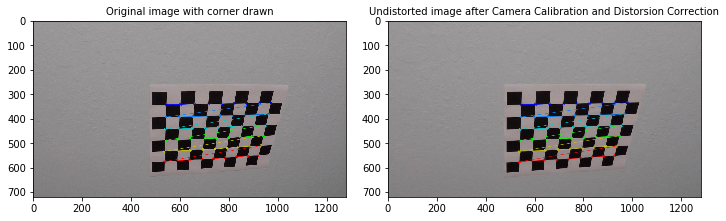

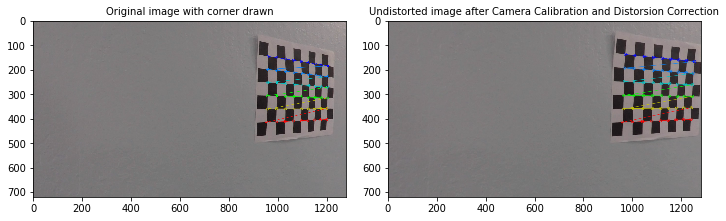

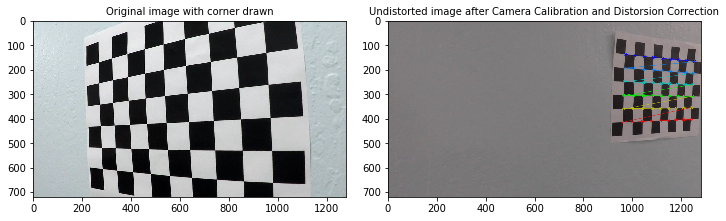

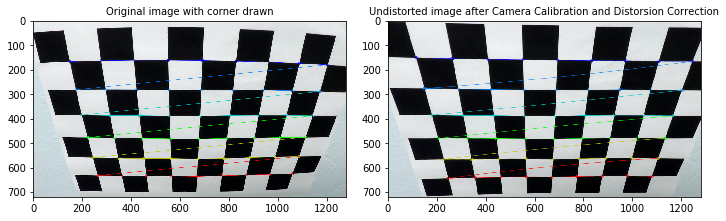

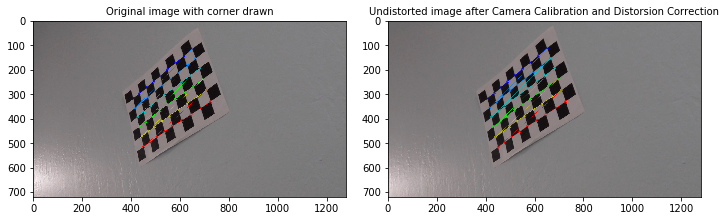

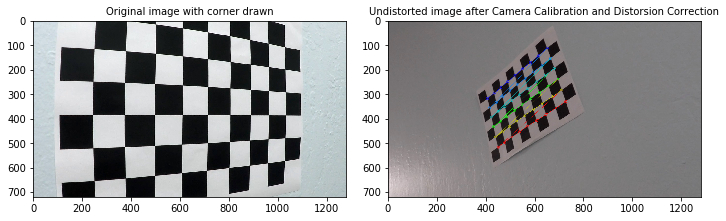

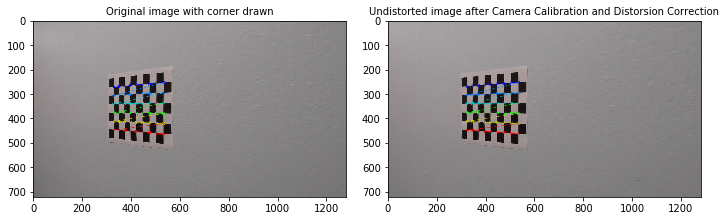

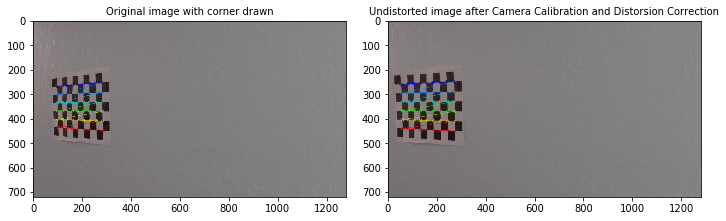

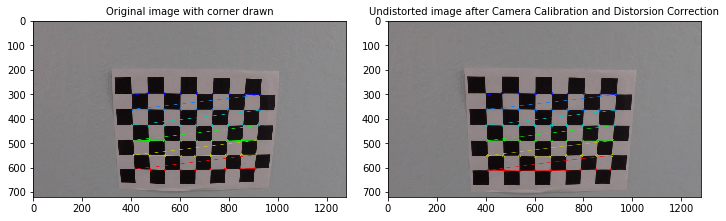

In [2]:
#--------------------------PRELIMINARY--------------------------------------------------------#
#--------------------------CAMERA CALIBRATION + DISTORSION CORRECTION-------------------------#

images = glob.glob('./camera_cal/calibration*.jpg')

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# input camera
objpoints = [] # 3d points - input camera
# output camera
imgpoints = [] # 2d points -output camera

# Chessboard "inside" corners
nx=9 # in x
ny=6 # in y

# Chessboard image
#image = 'camera_cal/calibration2.jpg'
#image_Chessboard = cv2.imread(image)

# Step through the list and search for chessboard corners
#for loop read all the images (1->20)
for fname in (images) :
    image_Chessboard = cv2.imread(fname)

    # Gray color
    gray = cv2.cvtColor(image_Chessboard, cv2.COLOR_BGR2GRAY)
    # (width,height) image chessboard
    shape = gray.shape[::-1] 
    # Find the corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    
        # Draw the corners
        cv2.drawChessboardCorners(image_Chessboard, (nx,ny), corners, ret)
        ## Camera Calibration
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
        # Distorsion Correction
        undist = cv2.undistort(image_Chessboard,mtx,dist,None,mtx)

#--------------------------DISPLAY----------------------------------------#        
    # Display to make the comparaison between the distorted image (befor image processing) 
    # and the undistorted image (after the distorsion correction)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    f.tight_layout()
    ax1.imshow(image_Chessboard)
    ax1.set_title('Original image with corner drawn', fontsize=10)
    ax2.imshow(undist)
    ax2.set_title('Undistorted image after Camera Calibration and Distorsion Correction', fontsize=10)
        
#-------------------------------Recording---------------------------------#
#mpimg.imsave ('output_images/Chessboard/Image2/original2.jpg', image_Chessboard)
#mpimg.imsave ('output_images/Chessboard/Image2/camera_calibration_undistorded2.jpg', undist)


Text(0.5,1,'Undistorted Image')

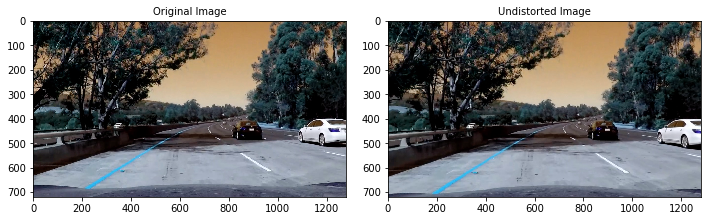

In [3]:

# STEP 1
# Test : Apply the distorsion correction for the differents vehicle images 
# function "calculation_undistort " is implemented in CV_function.py
# here you can see the result for the image 2

#image_v = 'test_images/test1.jpg'
image_v = 'test_images/test5.jpg'
#image_v = 'test_images/test3.jpg'
#image_v = 'test_images/test4.jpg'

image = cv2.imread(image_v)

#-----------------Distorsion correction----------------------#
#undist = cv2.undistort(image_vehicule,mtx,dist,None,mtx)
undist = calculation_undistort(image ,objpoints,imgpoints)

#------------------Display------------------------------------#
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=10)     
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=10)
#-------------------------------Recording---------------------#
#mpimg.imsave ('output_images/Vehicle_Distorsion_Correction/Image2/original2.jpg', image)
#mpimg.imsave ('output_images/Vehicle_Distorsion_Correction/Image2/undistorded2.jpg', undist)


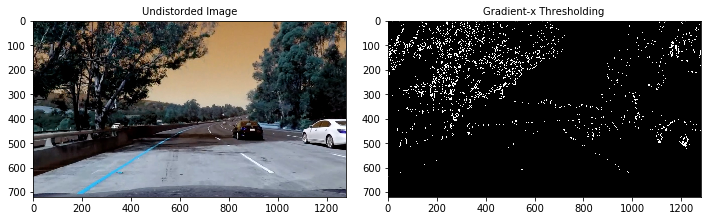

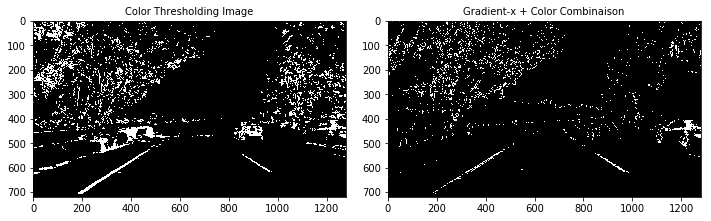

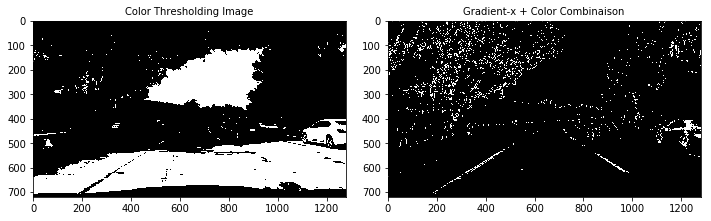

In [4]:
# STEP 2
# Test : Apply the differents threshold for the gradient (Solbel Method : -x, -y,-mag,-dir)
# and for the colors threshold (-S parameter) 
# Empiric method is used for the configuration   
# function "image computing" is implemented in CV_function.py
# here you can see the result for the image 2 defined in the beginning of the pipeline

#-----------------Call the fonction image_computing------------------#
sxbinary, sybinary, mag_binary, dir_binary, s_binary, l_binary, combined_binary, combined_binary_b = image_computing(undist)
#--------------------------------------------------------------------#

#-----------------Visualization--------------------------------------# 
# only the vizualizatio for the x-gradient, the magnitude gradienta and the totally combinaison (x gradient/mag/direction + color)
f, (ax1, ax2)  = plt.subplots(1,2, figsize=(10, 10))
f.tight_layout()
ax1.imshow(sxbinary, cmap ='gray')
ax1.set_title('Gradient-x Thresholding', fontsize=10)
ax1.imshow(l_binary, cmap ='gray')
ax1.set_title('Undistorded Image', fontsize=10)


f, (ax3, ax4)  = plt.subplots(1,2, figsize=(10, 10))
f.tight_layout()
ax3.imshow(s_binary, cmap ='gray')
ax3.set_title('Color Thresholding Image', fontsize=10)
ax4.imshow(combined_binary, cmap ='gray')
ax4.set_title('Gradient-x + Color Combinaison', fontsize=10)


#--------------------Recording------------------------------------------#
mpimg.imsave('output_images/Computing_Gradient_Color/Image2/threshold_gradient.jpg', sxbinary)
mpimg.imsave('output_images/Computing_Gradient_Color/Image2/threshold_color_l_channel.jpg', l_binary)
mpimg.imsave('output_images/Computing_Gradient_Color/Image2/threshold_color_s_channel.jpg', s_binary)
mpimg.imsave('output_images/Computing_Gradient_Color/Image2/combined_binary.jpg', combined_binary)

In [ ]:
# STEP 3
# Test : Apply a perspective transform to rectify binary image ("birds-eye view")
# # the target is to choice 4 points very far in the image to have a better analyze
# function "warper" is implemented in CV_function.py
# here you can see the result for the image 2 defined in the beginning of the pipeline


shape = combined_binary.shape[::-1]

# first configuration 
#src = np.float32([ [550,450], [150,shape[1]], [1150,shape[1]], [800,450]])
#dst = np.float32([ [0,0], [0,shape[1]], [shape[0],shape[1]], [shape[0],0]])

# configuration given in the reporting 
src = np.float32([[585,460], [203,720], [1050,720], [695,460]])
dst = np.float32([ [320,0], [320,720], [960,720], [960,0]])

#--------------------------- Call the function Warp---------------------
warped,Minv = warper(combined_binary, src, dst)


#----------------------------Visualization-------------------------------
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.set_title('Undistorted  + Gradient Tresholded(-x) + Color Thresholded')
ax1.imshow(combined_binary, cmap='gray')

ax2.set_title('Undistorted + Warped')
ax2.imshow(warped, cmap='gray')

mpimg.imsave('output_images/Warped_Perspective_Transform/Image2/combined_binary.jpg', combined_binary)
mpimg.imsave('output_images/Warped_Perspective_Transform/Image2/Bird_view.jpg', warped)

In [ ]:
# STEP 4
# Test : Define the dedicated pixels  for the lines left  (in -x and -y)
# and the the dedicated pixels for the lines right (in -x and -y)
# function "fit_polynomial" is implemented in CV_function.py
# here you can see the result (4 lists) for the image 2 defined at the beginning of the pipeline
# ans the histogram

leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds = find_lanes_pixels(warped)
print (leftx, lefty, rightx, righty)

In [ ]:
# STEP 5
# Test : Calculate the 2 polynomials functions for the two lines (left and right)
# function "fit_polynomial" is implemented in CV_function.py
# here you can see the result for the image 2 defined in the beginning of the pipeline
left_fit, right_fit, ploty, left_fitx, right_fitx, out_img= fit_polynomial (warped, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds)
# Plots the left and right polynomials on the lane lines
plt.imshow (out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
mpimg.imsave('output_images/Pixels_found_Polynome_Curve/Image2/polynome.jpg', out_img)


In [ ]:
# STEP 6
# Test : Calculate the radius of curvature in meters for both lane lines
# function "calculation_curvature" is implemented in CV_function.py
# here you can see the result for the image 2 defined in the beginning of the pipeline

left_radius_curve,right_radius_curve = calculation_curvature (leftx, lefty, rightx, righty)
print("left curvature :", left_radius_curve, 'meters')
print( "right curvature : " , right_radius_curve, 'meters')

In [ ]:
# STEP 7
# Test : Call the function for the position of the vehicule 
# function "vehicle position" is implemented in CV_function.py
# here you can see the result for the image 2 defined in the beginning of the pipeline

vehicle_position = calculation_vehicle_position (undist, left_fit, right_fit)
print ("vehicle is: ",vehicle_position, 'meters of the center')

In [ ]:
# STEP 8
# Test : Call the function vizualization with all the parameters 
# function "vizualization" is implemented in CV_function.py
# here you can see the result for the image 2 defined in the beginning of the pipeline

result  = vizualization (undist, left_fit, right_fit, Minv, left_radius_curve, right_radius_curve, vehicle_position)
plt.imshow(result)
mpimg.imsave('output_images/finale_Vizualization/Image2/finale_Vizualization_1.jpg', result)


In [ ]:

#############################"PIPELINE"############################################################
def process_image(image):
    #Step 1 = camera calibration + image undistorted 
    undist =calculation_undistort(image,objpoints,imgpoints)
    
    #Step 2 = Threshold (gradient (-x/-y/-mag/-dir) and color) configuration and threshold combinaison
    _, _, _, _, _,_, combined_binary,_ = image_computing(undist)
    
    #Step 3 = Perspective Transform, the target is to select 4 points very far in the image foe a better analyze
    # This function returns Minv, because he will be use in the Step, in the reconstitution step
    warped,Minv = warper(combined_binary, src, dst)
    
    #Step 4 : the target is to know the dedicated pixels for the lane right and the lane left 
    # the standard method named "peak/histogram" is used (convolution mathod not used) with windows configured with hyperparameters
    leftx, lefty, rightx, righty,left_lane_inds, right_lane_inds = find_lanes_pixels(warped)
    
    #Step 5 = polynomial fonction for the right and the left curve
    left_fit, right_fit, ploty, left_fitx, right_fitx, out_img= fit_polynomial (warped, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds)
   
    #Step 6 = Diagnostic information 1 : curvature calculation (space conversion : from "pixel" world to "meters" world)
    left_radius_curve,right_radius_curve = calculation_curvature (leftx, lefty, rightx, righty)
    
    #Step 7 = Diagnostic information 2 : deviation of the vehicle with the "central line" reference
    vehicle_position = calculation_vehicle_position (undist, left_fit, right_fit)
    
    #Step 8 = Vizualization of the image (before processing) with all the informations (diagnostics + lane detection tracking)
    result = vizualization(undist, left_fit, right_fit, Minv, left_radius_curve, left_radius_curve, vehicle_position)
     
    return result  
       

In [ ]:
########################TEST WITH THE IMAGES############################

image_v = 'test_images/test5.jpg'
#image_v = 'test_images/straight_lines2.jpg'
image = cv2.imread(image_v)
result = process_image(image)
plt.imshow(result)
mpimg.imsave('output_images/finale_Vizualization/finale_Vizualization_5.jpg', result)


In [ ]:

# test video

video_output = "output_video/project_video.mp4"
clip1 = VideoFileClip("project_video.mp4")

video_clip = clip1.fl_image(process_image) 
#video_clip = clip2.fl_image(process_image)

%time video_clip.write_videofile(video_output, audio=False)


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))